<a href="https://colab.research.google.com/github/TeCai/diffusion_playground/blob/main/Diffusion_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [ ]:
import IPython
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Module
import os
from pathlib import Path
import torchvision.transforms as transforms

import PIL
import matplotlib.pyplot as plt

from pathlib import Path
import torchvision
# import torchvision.transforms.functional as TF
import scipy
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from scipy.io.wavfile import read

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set random seed

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

Set device

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


https://drive.google.com/drive/folders/1X7qjmZpMoukGVl6THDZ8nvsE84M_x27C?usp=sharing

Link for model weights

In [ ]:
# change this location to your own google drive location
models_dir = Path("./drive/MyDrive/Diffusion_ckpt")


### Utility functions

In [ ]:
def plot_images(images, titles, texts):
    N_cols = len(images)
    N_rows = len(images[0])

    fig, axs = plt.subplots(N_rows, N_cols, figsize=(20, 15))

    if titles is not None:
        for i, ax in enumerate(axs[0]):
            ax.set_title(titles[i])

    for i, img_col in enumerate(images):
        for j, img in enumerate(img_col):
            if len(img.shape) == 2:
                axs[j,i].imshow(img, interpolation='nearest', cmap='gray')
            else:
                axs[j,i].imshow(img, interpolation='nearest')
            axs[j,i].axis('off')
            if texts is not None:
                axs[j,i].text(0.5,-0.1, str(texts[j][i])[:4], size=10, ha="center", transform=axs[j,i].transAxes)
    plt.show()


Create the VAE class

In [ ]:
class VAE(Module):

    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        self.channel_size    = channel_size


        #solution
        # input is 3x 256 x 256, need more channels than mnist
        self.convblock1 = nn.Sequential(
            nn.Conv2d(self.channel_size, 32, (3,3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.pool1 = nn.MaxPool2d(2) # After this 32*128*128

        self.convblock2 = nn.Sequential(
            nn.Conv2d(32, 64, (3,3), padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.pool2 = nn.MaxPool2d(2) # after this 64*64*64
        self.convblock3 = nn.Sequential(
            nn.Conv2d(64, 128, (3,3), padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.pool3 = nn.MaxPool2d(2) # after this 128*32*32
        self.convblock4 = nn.Sequential(
            nn.Conv2d(128, 256, (3,3), padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.pool4 = nn.MaxPool2d(2) # after this 256*16*16
        self.convblock5 = nn.Sequential(
            nn.Conv2d(256, 128, (3,3), padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, (3,3), padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.pool5 = nn.MaxPool2d(2) # after this 64*8*8


        self.flatten = nn.Flatten()
        self.fclayermean = nn.Sequential(
            # A little modification of output of mean, since standard normal, don't use relu
            nn.Linear(64*8*8, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, self.bottleneck_size),
        )
        self.fclayerstd = nn.Sequential(
            nn.Linear(64*8*8, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, self.bottleneck_size)#  produce log(std)
        )


        # decoder part
        self.latent_to_img = nn.Sequential(
            nn.Linear(self.bottleneck_size, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 64*8*8),
            nn.ReLU(),
            nn.BatchNorm1d(64*8*8)
        ) # after this B x 64*8*8

        self.convb0  = nn.Sequential(
            nn.Conv2d(64, 128, (3,3), padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, (3,3), padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        ) # after this B x 256 x 8x 8

        self.upconv1 = nn.Sequential(nn.ConvTranspose2d(256, 256, (4,4), stride = 2, padding = 1)) # after this 256*16*16
        self.convb1 = nn.Sequential(
            nn.Conv2d(256, 256, (3,3), padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.upconv2 = nn.Sequential(nn.ConvTranspose2d(256, 128, (4,4), stride = 2, padding = 1)) # after this 128*32*32
        self.convb2 = nn.Sequential(
            nn.Conv2d(128, 128, (3,3), padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.upconv3 = nn.ConvTranspose2d(128, 64, (4,4), stride = 2, padding = 1) # after this 64*64*64
        self.convb3 = nn.Sequential(
            nn.Conv2d(64, 64, (3,3), padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.upconv4 = nn.ConvTranspose2d(64, 32, (4,4), stride = 2, padding = 1) # after this 32*128*128
        self.convb4 = nn.Sequential(
            nn.Conv2d(32, 32, (3,3), padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.upconv5 = nn.ConvTranspose2d(32, 32, (4,4), stride = 2, padding = 1)# after this 32*256*256


        self.outputconv = nn.Sequential(
            nn.Conv2d(32, 16, (3,3), padding = 'same'),
            nn.ReLU(0.1),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 3, (3,3), padding = 'same'),
            nn.Sigmoid()  # since figure is (0,1)
        )

        self.encoder_block = [self.convblock1, self.pool1, self.convblock2, self.pool2, self.convblock3, self.pool3, self.convblock4, self.pool4,
                                self.convblock5, self.pool5]
        self.decoder_list = [self.convb0, self.upconv1, self.convb1, self.upconv2, self.convb2, self.upconv3, self.convb3, self.upconv4, self.convb4,
                            self.upconv5]

        #end_solution


    def encoder(self,image):

        #solution
        for layer in self.encoder_block:
            image = layer(image)
        x = self.flatten(image)
        mu = self.fclayermean(x)
        std = torch.exp(self.fclayerstd(x))

        #end_solution


        return mu, std

    def reparametrization_trick(self,mu,std):

        #solution
        ep = torch.randn_like(mu).to(device)
        z = mu + ep*std
        # torch.randn_like()

        #end_solution


        return z

    def decoder(self,code):
        #solution
        x = self.latent_to_img(code)
        x = torch.reshape(x, shape = (-1, 64,8,8))
        for layer in self.decoder_list:
            x = layer(x)





        decoded_image  = self.outputconv(x)



        return decoded_image

    def forward(self, image):


        mu, std = self.encoder(image)
        z = self.reparametrization_trick(mu, std)
        decoded_image = self.decoder(z)



        return decoded_image, mu, std

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Load pretrained model

In [ ]:
celeba_hq_vae = torch.load(models_dir/"ex3d.pth")

Reconstructions of the VAE model 5 samples from the validation dataset. Note we use the latent-code means for decoding the reconstruction.

Show 10 Random samples drawn from the trained CelebA-HQ VAE. You can use the `plot_images` function provided to you.

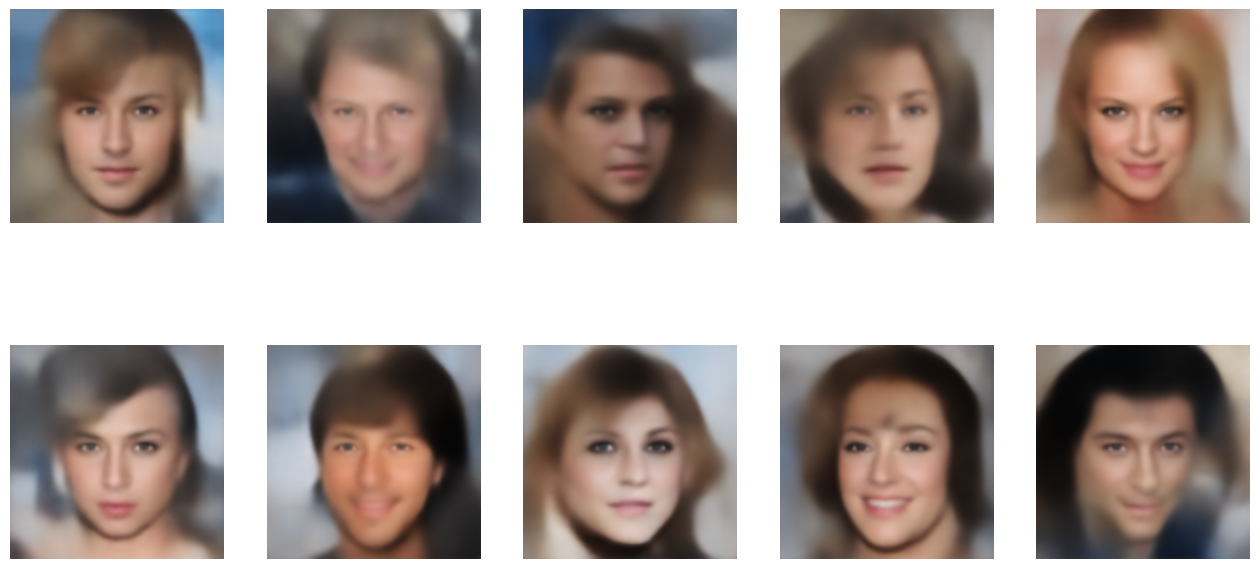

In [ ]:
number_of_samples = 10


#solution
input = torch.randn(size = (number_of_samples,100)).to(device)
with torch.no_grad():
  image = celeba_hq_vae.decoder(input)

result = [ el.cpu().squeeze().numpy() for el in image.permute(0,2,3,1)]

n_cols = 5
n_rows = 2
f, axs = plt.subplots(n_rows, n_cols, figsize=(16, 8))

for n, images in enumerate(result):
  i = n // n_cols
  j = n % n_cols
  # image = result[n].cpu().permute(1,2,0)
  axs[i, j].imshow(images)
  axs[i, j].axis('off')

#end_solution


## Try Diffusion

Since the image generated by VAE is blurry, I want to use diffusion to make it look sharper and detailed, which is a common trick. So, I built and trained my own diffusion model. The dataset used is CelebA-HQ but resized to (64,64,3), because larger images take centuries to train. The model is trained on an RTX3090 for about 40 hours. (Can actually be shorter if some dynamic learning rate adjusting tricks are implemented.)

This part is just for fun. You are welcomed to run the code block by block and load the trained weights to play around with it. Or you can just scroll down to see what happens.

The training part of the code is not included, but in another script which is not provided because I don't think it is necessary.

In [ ]:
# pre_define all things
class Para_bag():
    def __init__(self, beta_start = 1e-4, beta_end = 0.02, T = 500):
        self.T = T

        self.betas  = torch.linspace(beta_start, beta_end, T)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)
        self.alphas_bar_sqrt = torch.sqrt(self.alphas_bar)
        self.sqrt_one_minus_alphabar = torch.sqrt(1 - self.alphas_bar)

    def register(self, register_buffer):
        # register them to float 32 and on device
        register_buffer('betas', self.betas)
        register_buffer('alphas', self.alphas)
        register_buffer('alphas_recip', 1./self.alphas)
        register_buffer('alphas_bar', self.alphas_bar)
        # for q(x_t|x_{t-1})
        register_buffer('alphas_bar_sqrt', self.alphas_bar_sqrt)
        register_buffer('sqrt_one_minus_alphabar', torch.sqrt(1 - self.alphas_bar))
        register_buffer('log_one_minus_alphabar', torch.log(1-self.alphas_bar))
        register_buffer('sqrt_recip_alphabar', 1/torch.sqrt(self.alphas_bar))
        register_buffer('sqrt_recip_alphabar_m1', torch.sqrt(1./self.alphas_bar -1.))

        # for posterior q(x_t-1|x_t, x_0)
        # note that beta_tilde_1 should actually be 0, for numerical stabillity,
        # we set them to 1e-20
        beta_tilde = (1. - self.alphas_bar[:-1]) / (1. - self.alphas_bar[1:])*self.betas[1:]
        beta_tilde = F.pad(beta_tilde, (0,1), value = 1e-20)
        alphas_per = F.pad(self.alphas_bar[:-1], (1, 0), value = 1.)
        register_buffer('log_beta_tilde', torch.log(beta_tilde))
        # following is not used if use equation 11 to sample, (sample with clamp, which produces better results without clamp)
        register_buffer('x0_coef', self.betas * torch.sqrt(alphas_per)/(1. - self.alphas_bar))
        register_buffer('x1_coef', torch.sqrt(self.alphas)*(1 - alphas_per)/(1.- self.alphas_bar))





# T = 500

# betas  = torch.linspace(1e-4, 0.02, T)
# alphas = 1 - betas
# alphas_bar = torch.cumprod(alphas, 0)
# alphas_bar_sqrt = torch.sqrt(alphas_bar)
# sqrt_one_minus_alphabar = torch.sqrt(1 - alphas_bar)



In [ ]:
# A sin time embedding commonly used in attention
class Sin_time_embed(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self,x):
        device = x.device
        sin_dim = self.dim // 2
        emb = np.log(10000)/(sin_dim - 1)
        emb = torch.exp(torch.arange(sin_dim, device=device) * -emb)
        emb = x[:,None] * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim = -1)
        return emb

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.proj(x)
        x = self.norm(x)

        x = self.act(x)
        return x



class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out )
        ) if time_emb_dim is not None else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        h = self.block1(x)

        # The time embedding here is a simplyfied version compared to the original version

        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            # print(time_emb.shape)
            time_emb = time_emb[...,None,None]

            h = time_emb + h # time embedding as addition



        h = self.block2(h)

        return h + self.res_conv(x)


In [ ]:
def Downsample(dim, dim_out = None):
    return nn.Conv2d(dim, dim_out if dim_out is not None else dim, 2, stride=2)


# Didn't use convtranspose since the number of parameters is already very large.
def Upsample(dim, dim_out= None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'bilinear'),
        nn.Conv2d(dim, dim_out, 3, padding = 'same')
    )

In [ ]:
# Decided to add attention layer because we some how need more global information
# Later on I find that dot product attention is too expensive for either memory or computation for unshrinked image
class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_heads = 32):
        super().__init__()

        self.scale = dim_heads ** -0.5 # for numerically stability
        self.heads = heads
        self.dim_heads = dim_heads

        hidden_dim = heads * dim_heads
        self.to_q = nn.Conv2d(dim, hidden_dim, 1, bias=False)
        self.to_k = nn.Conv2d(dim, hidden_dim, 1, bias=False)
        self.to_v = nn.Conv2d(dim, hidden_dim, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape

        q = self.to_q(x).view(b, self.heads, self.dim_heads, h*w) # B (h c) h w
        k = self.to_k(x).view(b, self.heads, self.dim_heads, h*w)
        v = self.to_v(x).view(b, self.heads, self.dim_heads, h*w)

        q = q*self.scale

        sim = torch.einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = torch.einsum('b h i j, b h d j -> b h i d', attn, v)
        out = out.permute((0,1,3,2)).reshape((b,self.heads*self.dim_heads, h, w ))

        return self.to_out(out)



In [ ]:

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_heads = 32):
        super().__init__()
        self.scale = dim_heads ** -0.5
        self.heads = heads
        self.dim_heads = dim_heads
        hidden_dim = dim_heads * heads
        self.to_q = nn.Conv2d(dim, hidden_dim, 1, bias=False)
        self.to_k = nn.Conv2d(dim, hidden_dim, 1, bias=False)
        self.to_v = nn.Conv2d(dim, hidden_dim, 1, bias=False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape

        q = self.to_q(x).view(b, self.heads, self.dim_heads, h*w) # B (h c) h w
        k = self.to_k(x).view(b, self.heads, self.dim_heads, h*w)
        v = self.to_v(x).view(b, self.heads, self.dim_heads, h*w)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out =  out.view((b, self.heads*self.dim_heads, h, w ))
        return self.to_out(out)


In [ ]:
# group norm and residule function
# These two codes are just copy and paste, from https://github.com/lucidrains/denoising-diffusion-pytorch/tree/main/denoising_diffusion_pytorch

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


In [ ]:
class Unet(Module):
    # reference https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py

    def __init__(self, dim, input_channel, init_dim = 16, expand_list = (1,2,4,8), mid_dim_factor = 1):
        super(Unet, self).__init__()

        # time embedding
        sin_time_emb = Sin_time_embed(dim)
        time_dim = dim*4
        self.time_mlp = nn.Sequential(
            sin_time_emb,
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )


        # sin_time_emb = Sin_time_embed(dim)
        # f_dim = dim


        self.init_conv = nn.Conv2d(input_channel, init_dim, 7, padding = 3)# after this B*init*256*256
        dims = [init_dim, *map(lambda m: dim*m, expand_list)]
        self.mid_dim = dims[-1] * mid_dim_factor
        self.input_channel = input_channel
        # print(dims) # (32,64,128,256)

        self.downs = nn.ModuleList([])
        self.up = nn.ModuleList([])

        # if dims = (32,64,128,256)
        #B*32*256*256, 64*128*128, 128*64*64, 256*32*32

        for index in range(len(dims)-1):
            dim_in = dims[index]
            dim_out = dims[index +1]
            self.downs.append(nn.ModuleList([
                ResnetBlock(dim_in, dim_in, time_emb_dim = time_dim),
                ResnetBlock(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))), # use linear attention because it is cheap
                Downsample(dim_in, dim_out) if index != len(dims)-2 else nn.Conv2d(dim_in, dim_out, 3, padding='same')
            ])) # after this 256*32*32

        # self.downs.append(nn.ModuleList([
        #     ResnetBlock(dims[-1], dims[-1], time_emb_dim = time_dim),
        #     ResnetBlock(dims[-1], dims[-1], time_emb_dim = time_dim),
        #     nn.Conv2d(dims[-1],dims[-1],padding = 'same')
        # ]))

        self.mid_block1 = ResnetBlock(dims[-1], self.mid_dim, time_emb_dim= time_dim)
        self.mid_block2 = ResnetBlock(self.mid_dim, dims[-1], time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(self.mid_dim, Attention(self.mid_dim))) # basically here 32 by 32 so we can use full attention




        # self.up1 = Upsample(dims[-1]*2, dims[-1])

        r_dims = dims.copy()
        r_dims.reverse()
        for index in range(len(dims)-1):
            dim_out = r_dims[index]
            dim_in = r_dims[index + 1]

            self.up.append(nn.ModuleList([
                ResnetBlock(dim_in + dim_out, dim_out, time_emb_dim = time_dim),
                ResnetBlock(dim_in + dim_out, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if index != len(dims)-2 else nn.Conv2d(dim_out, dim_in,3,padding = 'same')
            ]))


        self.last_b1 =  ResnetBlock(init_dim*2, init_dim, time_emb_dim=time_dim)
        self.last_b2 =  ResnetBlock(init_dim, init_dim, time_emb_dim = time_dim)
        self.output =   nn.Conv2d(init_dim, input_channel, 1)


    def forward(self, x, time):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)
        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x,t)
            h.append(x)
            # print(x.shape)

            x = block2(x,t)
            x = attn(x)
            h.append(x)
            # print(x.shape)

            x = downsample(x)

        x = self.mid_block1(x)
        x = self.mid_attn(x)
        x = self.mid_block2(x)



        # print('start sample')

        for block1, block2, attn, upsample in self.up:

            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x,t)
            # print(x.shape)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x,t)
            x = attn(x)
            # print(x.shape)

            x = upsample(x)
            # print(x.shape)

        # print('end up sample')
        x = torch.cat((x,r), dim = 1)
        # print(x.shape)
        x = self.last_b1(x)
        x = self.last_b2(x)

        return self.output(x)



In [ ]:
# Juicy bit: build the diffusion model
class GaussianDiffusion(nn.Module):
    def __init__(self, model, para_bag, image_size, device):
        super().__init__()
        self.para_bag = para_bag
        self.model = model
        self.input_channel = model.input_channel
        self.image_size = image_size
        self.device = device


        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        self.para_bag.register(register_buffer = register_buffer)

    def extract(self,a,t):
        # this function use for extract the values in para_bag and
        # then expand dims
        b  = t.shape[0] #b is the batch size
        out = a[t]
        return out.reshape(b,1,1,1)



    # def from_x0_to_noise(self, x_t, t, x0):
    #     return ((self.extract(self.sqrt_recip_alphabar,t) * x_t - x0) / self.extract(self.sqrt_recip_alphabar_m1,t))

    def q_sample(self, x0, t, noise = None):
        # adding noise to a clear image
        if noise is None:
            noise = torch.randn_like(x0)

        return self.extract(self.alphas_bar_sqrt, t) * x0 + self.extract(self.sqrt_one_minus_alphabar, t)*noise


    # loss function
    def loss(self, x0, t, noise = None):
        if noise is None:
            noise = torch.randn_like(x0)

        x_noisy = self.q_sample(x0 = x0, t = t, noise = noise)
        predicted_noise = self.model(x_noisy, t)

        loss = F.mse_loss(noise, predicted_noise) # use mse_loss
        return loss

    def from_noise_to_x0(self, x_t, t, noise):
        return self.extract(self.sqrt_recip_alphabar,t) * x_t - self.extract(self.sqrt_recip_alphabar_m1,t) * noise


    # sampling step
    @torch.no_grad()
    def p_sample_step(self, xt, t, t_ind, clip = True):
        # from x_t  predict x_t-1
        betas_t = self.extract(self.betas, t)
        if clip == True:
            pred_noise = self.model(xt,t)
            pred_x0 = torch.clamp(self.from_noise_to_x0(xt, t, pred_noise), -1., 1.)
            mean = self.extract(self.x0_coef,t) * pred_x0 + self.extract(self.x1_coef,t)*xt

        else:
            mean = torch.sqrt(self.extract(self.alphas_recip, t))*(
                xt - betas_t/self.extract(self.sqrt_one_minus_alphabar, t)*self.model(xt,t))

        std = (self.extract(self.log_beta_tilde, t)*0.5).exp()
        noise = torch.randn_like(xt) if t_ind > 0 else 0.

        return mean + std*noise


    @torch.no_grad()
    def p_sample_from_t(self, from_t = None, img = None, return_all = False, batch_size = 1):
        # since we are adding noise to vae_result and then return clear image,
        # we need to sample from any time step
        # from_t and img should be given value at the same time

        if from_t is None:
            from_t = self.para_bag.T

        if img is None:
            img = torch.randn((batch_size, self.input_channel,self.image_size[0],self.image_size[1])).to(self.device)
        else:
            batch_size = img.shape[0]


        if return_all:
            imgs = []

        # many thanks for importing tqdm!
        for i in tqdm(reversed(range(0, from_t)), desc = 'time_step', total = from_t):
            img = self.p_sample_step(img, torch.full((batch_size,),i,device = self.device),i)
            if return_all:
                imgs.append((img.cpu().numpy()+1.)*0.5)

        return imgs if return_all else img

    @torch.no_grad()
    def sample(self, batchsize):
        return (self.p_sample_from_t(batch_size = batchsize)+1.)*0.5

    @torch.no_grad()
    def make_clear(self, img, t, return_all = False):
        ''' please input batchsize * 3 * 64*64 size image with range (0,1)
        return the clear version of the input image. The orginal
        image is inserted by noise to step t.
        if return_all is True, returns all intermediate image
        '''
        img = img*2.-1 # scale to -1, 1, as the orginal paper
        img = self.q_sample(img, torch.full((img.shape[0],),t,device = self.device))

        clear_img = self.p_sample_from_t(from_t=t, img = img, return_all=return_all)

        return (clear_img+1)*0.5

    def forward(self, img_batch):
        # b,c,h,w, = img_batch.shape

        # uniformly sample t
        t = torch.randint(0, self.para_bag.T, size = (img_batch.shape[0],), device = self.device)
        # torch.randint()
        return self.loss(img_batch, t)




In [ ]:
CELE_denoise = Unet(32, init_dim = 32, input_channel = 3, expand_list=(1,2,4,8,16)).to(device)
CELE_Diffusion = GaussianDiffusion(CELE_denoise,Para_bag(T = 1000),image_size=(64,64), device = device).to(device)

In [ ]:
CELE_Diffusion.load_state_dict(torch.load(models_dir/"diffusion_paras.pth"))

<All keys matched successfully>

In [ ]:
# enable gpu to sample faster
torch.random.manual_seed(226) # birthday seed :)
result = CELE_Diffusion.sample(50)

time_step:   0%|          | 0/1000 [00:00<?, ?it/s]

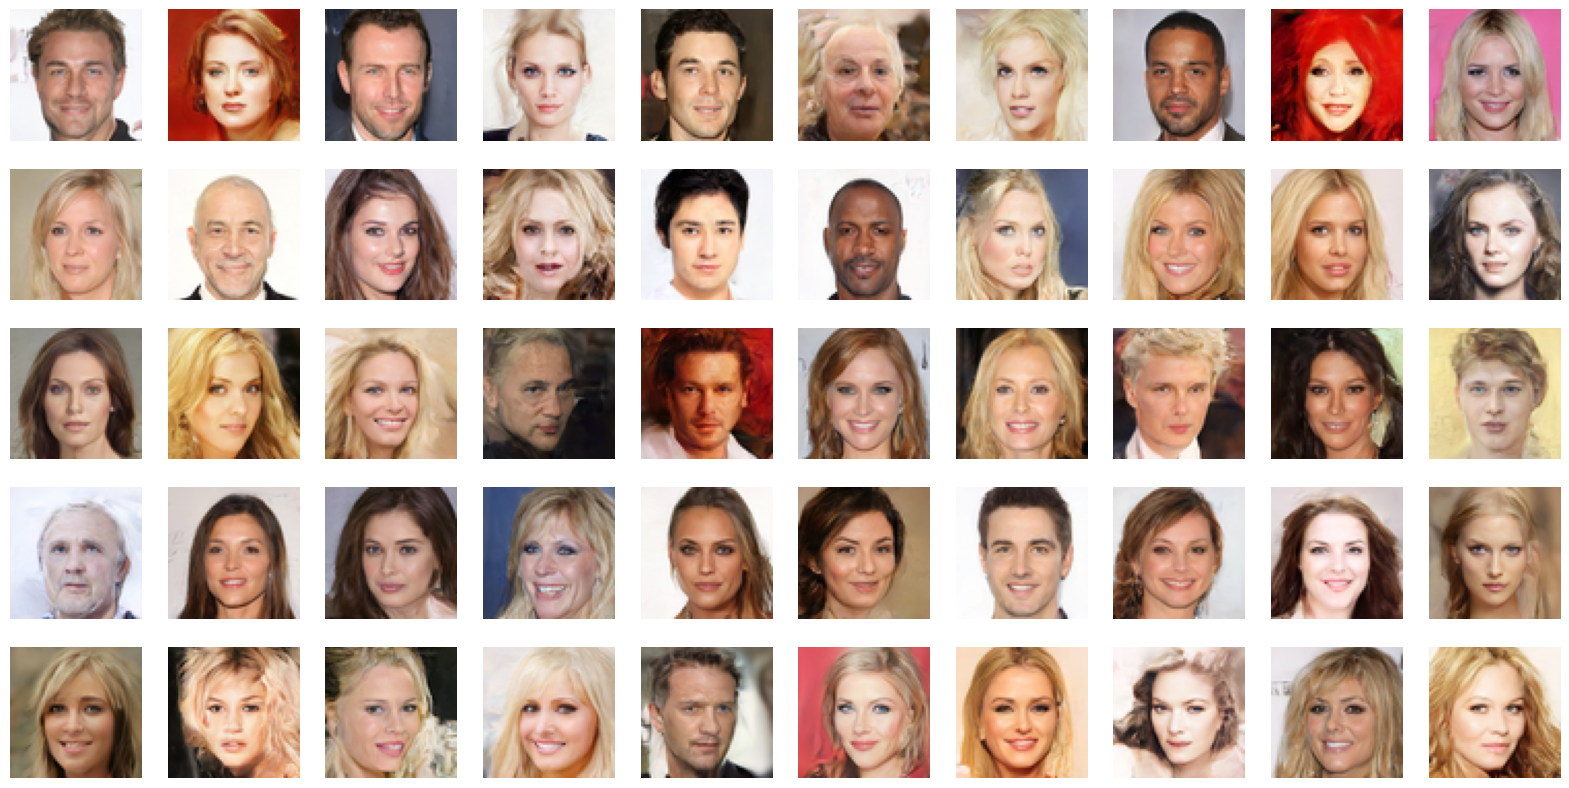

In [ ]:
n_cols = 10
n_rows = 5
f, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10))

for n in range(len(result)):
  i = n // n_cols
  j = n % n_cols
  image = result[n].cpu().permute(1,2,0)
  axs[i, j].imshow(image)
  axs[i, j].axis('off')

time_step:   0%|          | 0/1000 [00:00<?, ?it/s]

time_step:   0%|          | 0/250 [00:00<?, ?it/s]

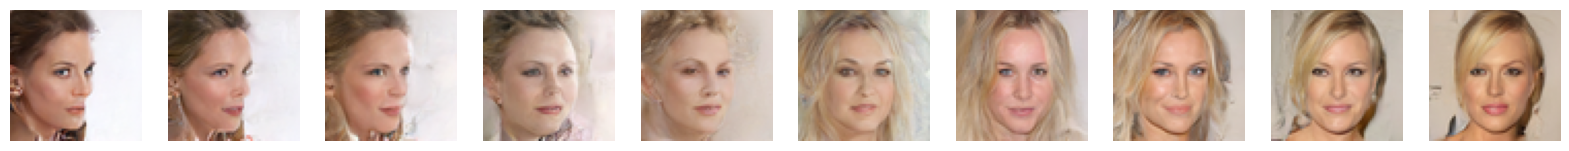

In [ ]:
# Try interpolation across faces

interp_steps = 10
from_t = 250   # decide from which time step you want to start to blur the image, you can adjust this from 1 to 1000 to see what happens


interp_para = np.linspace(0,1,interp_steps)
# randomly sample two images
torch.random.manual_seed(21103064)
source_image = CELE_Diffusion.sample(2)
figure_1 = source_image[0][None,...].cpu().clone()
figure_2 = source_image[1][None,...].cpu().clone()

input_img= torch.concatenate([(1.-t)*figure_1 + t*figure_2 for t in interp_para], dim=0) # simple linear interp in pixel space



result = CELE_Diffusion.make_clear(input_img.to(device), t = from_t)

n_cols = interp_steps
n_rows = 1
f, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10))

for n in range(interp_steps):
  image = result[n].cpu().permute(1,2,0)
  axs[n].imshow(image)
  axs[n].axis('off')



In [ ]:
# smaple k images from vae
k = 8


torch.random.manual_seed(2260)
input = torch.randn(size = (k,100)).to(device)
with torch.no_grad():
  image = celeba_hq_vae.decoder(input)
# resize to 64,64
image = torchvision.transforms.functional.resize(image, (64,64), interpolation= transforms.InterpolationMode.BICUBIC, antialias= True)

In [ ]:
# Adjust t from 0 to 1000, to see the effect. Generally the smaller T, the closer the generated images looks to the VAE Generated image

from_t = 250
torch.random.manual_seed(226)
clear_img = CELE_Diffusion.make_clear(t = from_t, img = image.to(device))

time_step:   0%|          | 0/250 [00:00<?, ?it/s]

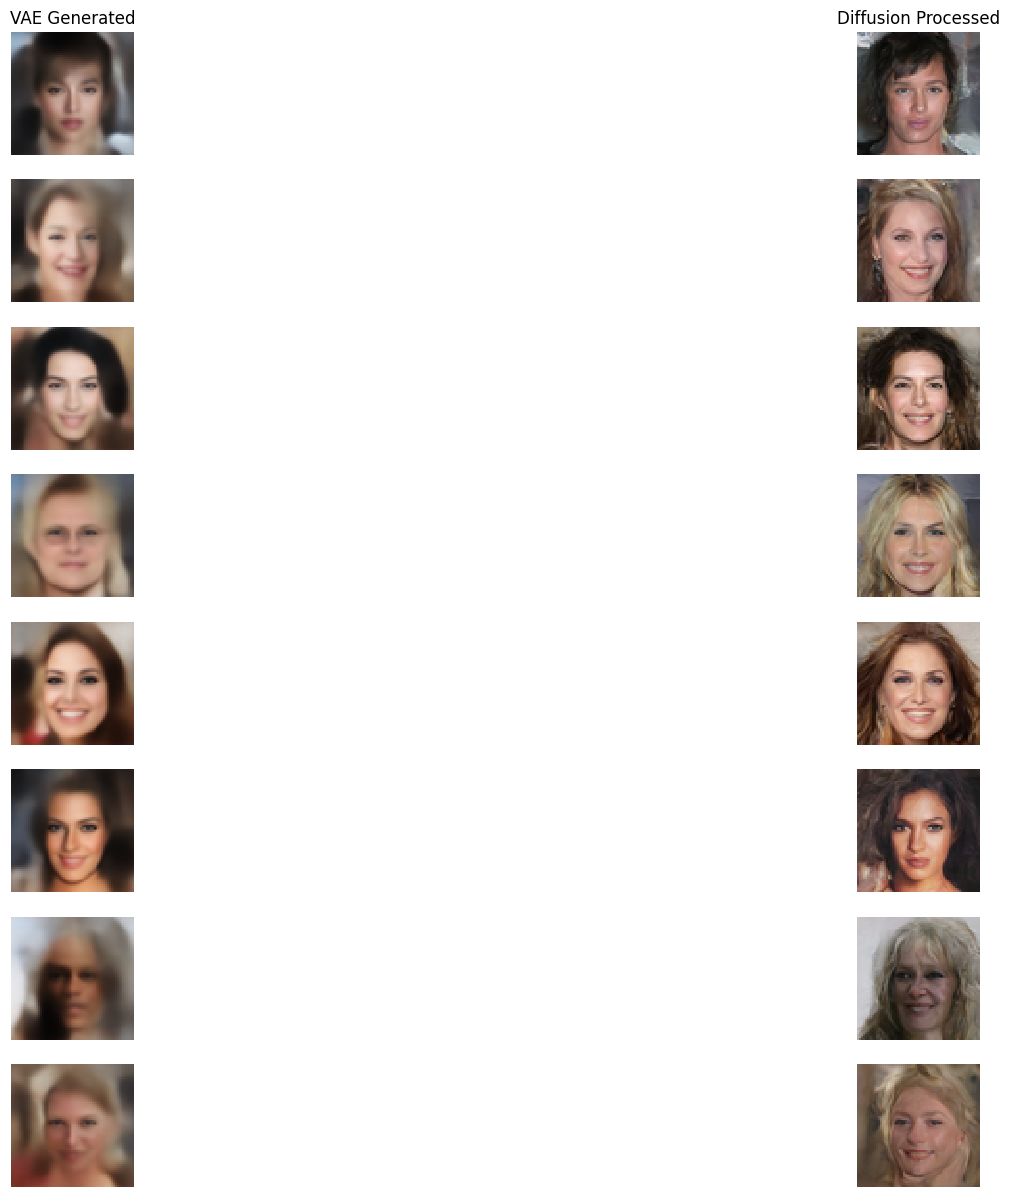

In [ ]:

imgs_plot = [ el.cpu().squeeze().numpy() for el in image.permute(0,2,3,1)]
clear_plot = [ el.cpu().squeeze().numpy() for el in clear_img.permute(0,2,3,1)]
plot_images([imgs_plot, clear_plot], ['VAE Generated','Diffusion Processed'], None)
